### Import Libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print("import libraries")

import libraries


### Import DataSet

In [49]:
df = pd.read_csv("insurance.csv")
df.head(5)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Data Preprocessing

In [50]:
X = df.drop(columns=['charges'])
y = df['charges']
print(X.shape, y.shape)

(1338, 6) (1338,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [52]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

In [53]:
num_pipe = Pipeline([
#    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

In [54]:
cat_pipe = Pipeline([
#    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

In [55]:
preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

In [56]:
knn_pipeline = Pipeline([
    ("preproc", preproc),
    ("knn", KNeighborsRegressor(
        n_neighbors=7,
        weights="distance",
        metric="euclidean",
        n_jobs=-1
    ))
])

In [57]:
y_train_log = np.log1p(y_train)

### Run KNN Model

In [58]:
print("Training KNN regressor...")
knn_pipeline.fit(X_train, y_train_log)
print("Training finished.")

Training KNN regressor...
Training finished.


In [59]:
y_pred_log = knn_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [60]:
rmse =root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [61]:
rel_errors = np.abs((y_test.values - y_pred) / np.where(y_test.values == 0, 1e-8, y_test.values))
error_percent = np.mean(rel_errors) * 100
accuracy_percent = 100.0 - error_percent

### Reuslts

In [62]:
print("\n=== Evaluation on Test Set ===")
print(f"Samples (train/test): {len(X_train)}/{len(X_test)}")
print(f"RMSE    : {rmse:.2f}")
print(f"MAE     : {mae:.2f}")
print(f"R²      : {r2:.4f}")
print(f"Error % : {error_percent:.2f}%")
print(f"Accuracy: {accuracy_percent:.2f}%")


=== Evaluation on Test Set ===
Samples (train/test): 1070/268
RMSE    : 5287.57
MAE     : 2967.38
R²      : 0.8243
Error % : 21.19%
Accuracy: 78.81%


In [63]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nFirst 10 predictions vs actual:")
print(results.head(10))


First 10 predictions vs actual:
           Actual     Predicted
578    9724.53000   9109.208351
610    8547.69130   8019.811203
569   45702.02235  38299.720792
1034  12950.07120  11637.605191
198    9644.25250  10691.815005
981    4500.33925   3371.701045
31     2198.18985   2816.505308
1256  11436.73815  13418.383361
1219   7537.16390   7884.432350
1320   5425.02335   7398.126145


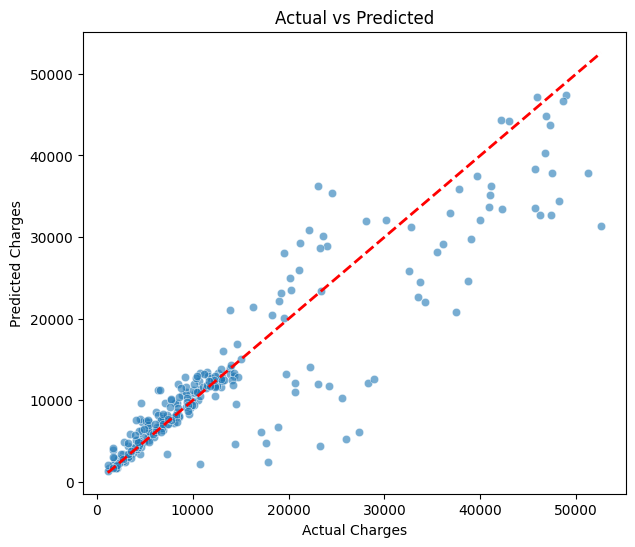

In [64]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted")
plt.show()


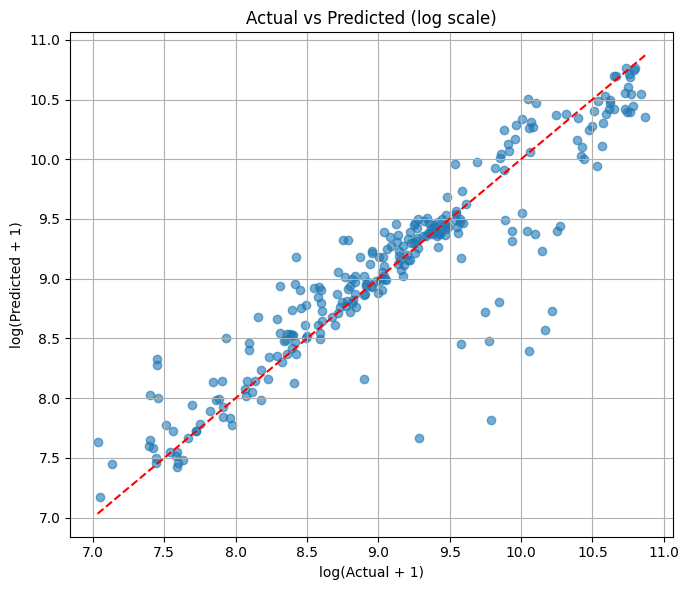

In [65]:
def to_log(arr):
    return np.log1p(arr)

def from_log(arr_log):
    return np.expm1(arr_log)
plt.figure(figsize=(7,6))
plt.scatter(to_log(y_test), to_log(y_pred), alpha=0.6)
mn = min(to_log(y_test).min(), to_log(y_pred).min())
mx = max(to_log(y_test).max(), to_log(y_pred).max())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='red')
plt.xlabel("log(Actual + 1)")
plt.ylabel("log(Predicted + 1)")
plt.title("Actual vs Predicted (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()